# Feed the input dataset into LSTM
## Selected Features: Eye gaze, Head pose, Au (EHA)

In [1]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
# from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
# from keras.layers import Attention
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, fbeta_score, auc, roc_auc_score
from sklearn.model_selection import KFold

import seaborn as sns


%matplotlib inline
# %matplotlib notebook

Experiment 2

Load dataset and data preparation

In [2]:
# 10 timesteps (averaged every 30 frames)
with open('daisee_openface/daisee_EHA.pkl','rb') as f:
    X_train_eye, X_val_eye, X_test_eye, X_train_head, X_val_head, X_test_head, X_train_au, X_val_au, X_test_au, Y_train_eye, Y_val_eye,  Y_test_eye= pickle.load(f)

# No feature selection (10 timesteps (averaged every 30 frames))
with open('daisee_openface/daisee_329dims_10timesteps.pkl','rb') as f:
    X_train_all, X_val_all, X_test_all, X_train_all_scalled, X_val_all_scalled, X_test_all_scalled,Y_train, Y_val, Y_test = pickle.load(f)

In [9]:
# stack all features
X_train = np.dstack((X_train_eye,X_train_head,X_train_au))
X_val = np.dstack((X_val_eye,X_val_head,X_val_au))
X_test = np.dstack ((X_test_eye,X_test_head,X_test_au))
print(X_train.shape,X_val.shape,X_test.shape)
print(X_train_all.shape, X_val_all.shape, X_test_all.shape)
print(X_train_all_scalled.shape, X_val_all_scalled.shape, X_test_all_scalled.shape)

(5467, 10, 23) (1703, 10, 23) (1782, 10, 23)
(5467, 10, 329) (1703, 10, 329) (1782, 10, 329)
(5467, 10, 329) (1703, 10, 329) (1782, 10, 329)


In [10]:
# Scalling EHA features input
tic = datetime.now()

scaler = MinMaxScaler(feature_range=(0,1))
X_train_scalled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

X_val_scalled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

X_test_scalled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

time = datetime.now() - tic
print('Processing time {}'.format(time))
print(X_train_scalled.shape,X_val_scalled.shape,X_test_scalled.shape)

Processing time 0:00:00.018000
(5467, 10, 23) (1703, 10, 23) (1782, 10, 23)


In [11]:
# To Categorical
Y_train = Y_train_eye
Y_train_cat = to_categorical(Y_train)
Y_val = Y_val_eye
Y_val_cat = to_categorical(Y_val)
Y_test = Y_test_eye
Y_test_cat = to_categorical(Y_test)
print('Y train',Y_train_cat)


Y train [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


# Model

In [6]:
def vanilaLSTM(X):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X.shape[1],X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))
    model._name='vanilaLSTM'
    print(model.summary())
    return model

def stackedLSTM(X):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    model.add(LSTM(75, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model._name='stackedLSTM'
    print(model.summary())
    return model

def biLSTM(X):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(X.shape[1],X.shape[2])))
    # model.add(Dropout(0.1))
    model.add(Dense(4, activation='softmax'))
    model._name='biLSTM'
    print(model.summary())
    return model

def biLSTM_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.2))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(4, activation='softmax'))
    model._name='biLSTM_en'
    print(model.summary())
    return model

In [7]:
# Instantiate the model
vanilaLSTM_model = vanilaLSTM(X_train)
vanilaLSTM_model_feat = vanilaLSTM(X_train_eye) #also for head
vanilaLSTM_model_au = vanilaLSTM(X_train_au)

stackedLSTM_model = stackedLSTM(X_train)
stackedLSTM_model_feat = stackedLSTM(X_train_eye)
stackedLSTM_model_au = stackedLSTM(X_train_au)

biLSTM_model = biLSTM(X_train)
biLSTM_model_feat = biLSTM(X_train_eye)
biLSTM_model_au = biLSTM(X_train_au)

biLSTM_en_model = biLSTM_en(X_train)
biLSTM_en_model_feat = biLSTM_en(X_train_eye)
biLSTM_en_model_au = biLSTM_en(X_train_au)

vanilaLSTM_model_all = vanilaLSTM(X_train_all_scalled)
stackedLSTM_model_all = stackedLSTM(X_train_all_scalled)
biLSTM_model_all = biLSTM(X_train_all_scalled)
biLSTM_en_model_all = biLSTM_en(X_train_all_scalled)

Model: "vanilaLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               49600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 50,004
Trainable params: 50,004
Non-trainable params: 0
_________________________________________________________________
None
Model: "vanilaLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
___________________________

In [8]:
# Compile, fit, and evaluate the model

def compile_train(model,Xtrain,Ytrain,Xval,Yval):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy',tf.keras.metrics.AUC()]) #

    filepath = 'weights/' + model.name + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.00001,mode='auto')

    es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20)
    history = model.fit(Xtrain,Ytrain, epochs=500, verbose=1,
                        callbacks = [PlotLossesCallback(), checkpoint, es],
                        batch_size = 32,
                        # validation_split=0.2,
                        validation_data = (Xval,Yval), 
                        shuffle=False,
                        class_weight = 'balanced'
                       ) 
    return history


def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    acc = accuracy_score(Ytest, pred) #accuracy
    f1 = f1_score(Ytest, pred, average='macro')
    fbeta = fbeta_score(Ytest, pred, average='macro', beta=4)
    auc = roc_auc_score(Ytest, trainedmodel.predict_proba(Xtest), average='macro', multi_class='ovr')
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error,
        '\n MSE = ',mse,
        '\n Accuracy = ',acc,
        '\n AUC = ', auc,
        '\n F1-score = ',f1,
        '\n Fbeta = ',fbeta
        )

        #  Plotting confusion matrix
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    cm = pd.DataFrame(cm,range(4),range(4))

    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    return 

# Train and compile


## 1. Vanila LSTM

No feature selection  (329 dimensions)

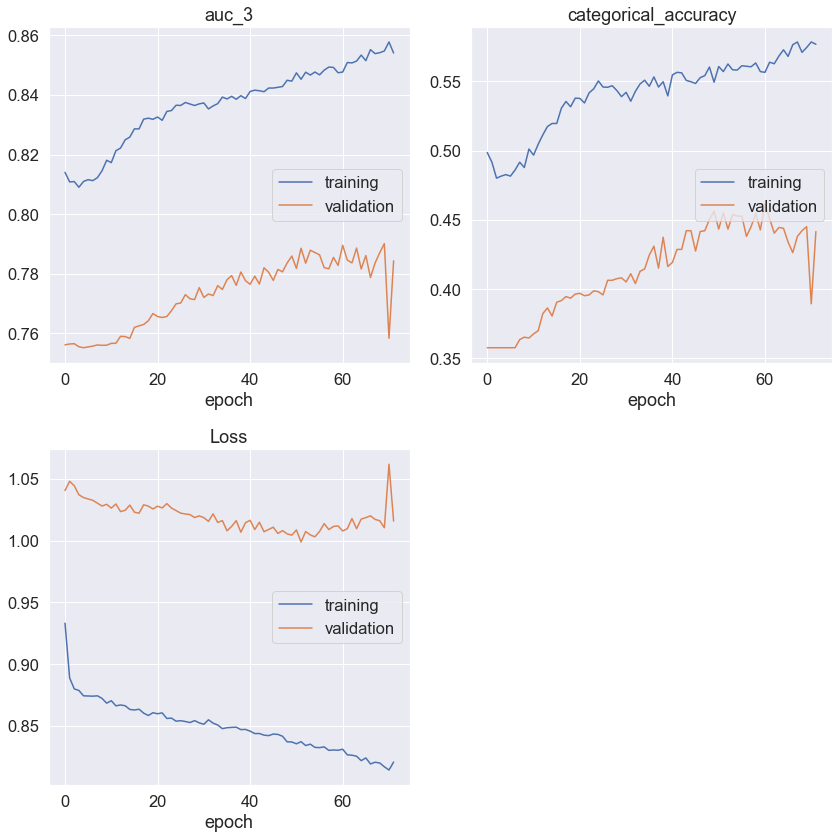

auc_3
	training         	 (min:    0.809, max:    0.858, cur:    0.854)
	validation       	 (min:    0.755, max:    0.790, cur:    0.784)
categorical_accuracy
	training         	 (min:    0.480, max:    0.579, cur:    0.577)
	validation       	 (min:    0.358, max:    0.462, cur:    0.442)
Loss
	training         	 (min:    0.814, max:    0.933, cur:    0.821)
	validation       	 (min:    0.999, max:    1.062, cur:    1.016)
5467/5467 [==============================] - 1s 197us/sample - loss: 0.8208 - categorical_accuracy: 0.5769 - auc_3: 0.8541 - val_loss: 1.0157 - val_categorical_accuracy: 0.4416 - val_auc_3: 0.7844
Training time:0:01:28.994745
1782/1782 [==============================] - 0s 75us/sample - loss: 0.8812 - categorical_accuracy: 0.4792 - auc_3: 0.8126
Accuracy on Test set: 47.92%
|vanilaLSTM|
 Error rate = 0.5207631874298541 
 MSE =  0.5858585858585859 
 Accuracy =  0.4792368125701459 
 AUC =  0.6223257761219259 
 F1-score =  0.24800360318567433 
 Fbeta =  0.2555716840342

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


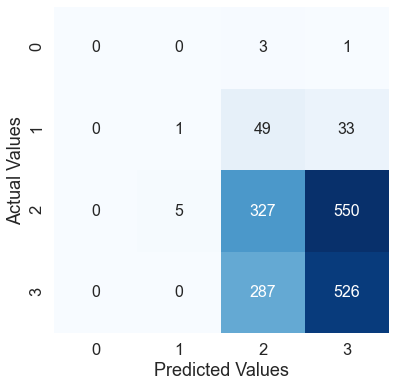

In [14]:
tic = datetime.now()

compile_train(vanilaLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model_all,X_test_all_scalled, Y_test))


EHA (non-scalled)

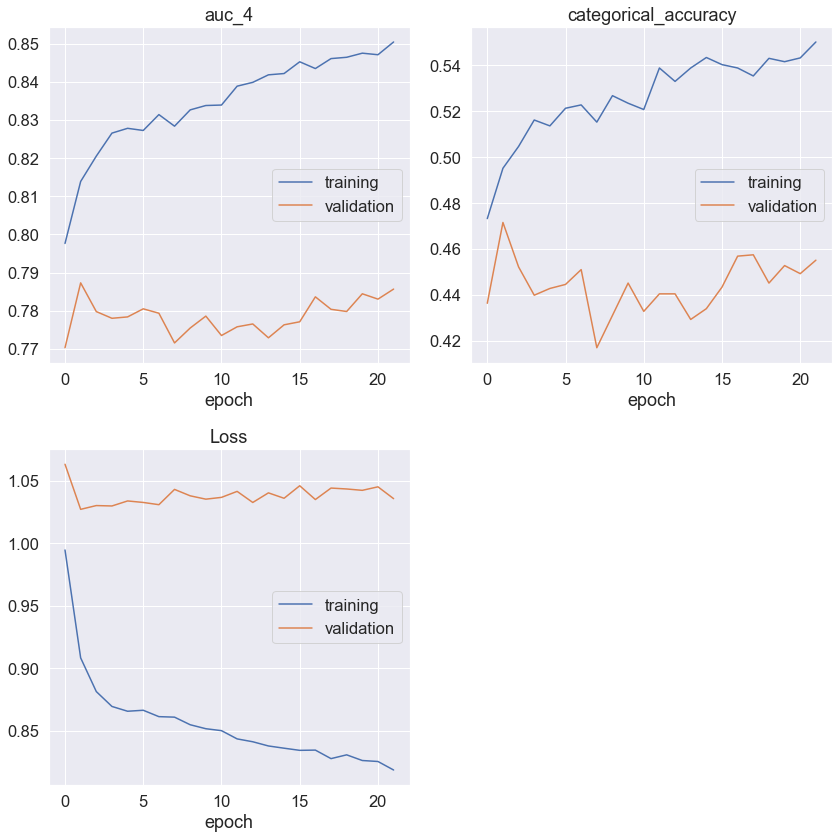

auc_4
	training         	 (min:    0.798, max:    0.850, cur:    0.850)
	validation       	 (min:    0.770, max:    0.787, cur:    0.786)
categorical_accuracy
	training         	 (min:    0.473, max:    0.550, cur:    0.550)
	validation       	 (min:    0.417, max:    0.472, cur:    0.455)
Loss
	training         	 (min:    0.818, max:    0.995, cur:    0.818)
	validation       	 (min:    1.027, max:    1.063, cur:    1.036)
5467/5467 [==============================] - 1s 201us/sample - loss: 0.8185 - categorical_accuracy: 0.5502 - auc_4: 0.8504 - val_loss: 1.0357 - val_categorical_accuracy: 0.4551 - val_auc_4: 0.7857
Training time:0:00:25.268478
1782/1782 [==============================] - 0s 73us/sample - loss: 0.8843 - categorical_accuracy: 0.4944 - auc_4: 0.8156
Accuracy on Test set: 49.44%
|vanilaLSTM|
 Error rate = 0.5056116722783389 
 MSE =  0.6122334455667789 
 Accuracy =  0.4943883277216611 
 AUC =  0.5150440707897208 
 F1-score =  0.25316916879899637 
 Fbeta =  0.2598370551259

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


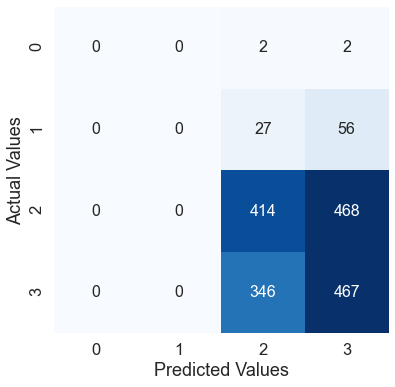

In [15]:
tic = datetime.now()

compile_train(vanilaLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(vanilaLSTM_model,X_test, Y_test))


EHA (scalled)

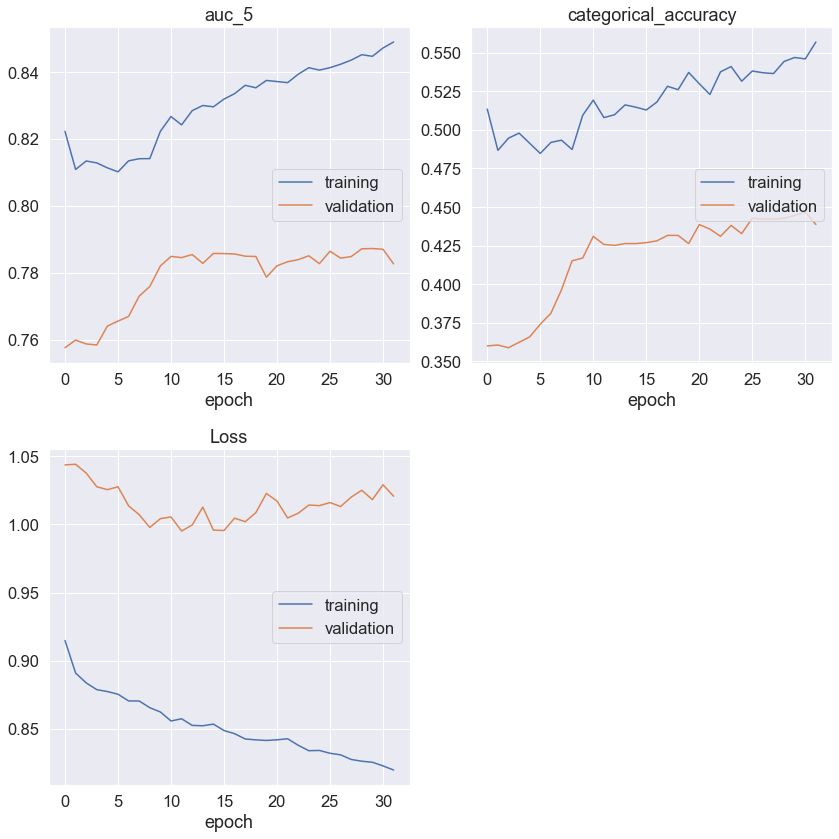

auc_5
	training         	 (min:    0.810, max:    0.849, cur:    0.849)
	validation       	 (min:    0.758, max:    0.787, cur:    0.783)
categorical_accuracy
	training         	 (min:    0.485, max:    0.557, cur:    0.557)
	validation       	 (min:    0.359, max:    0.447, cur:    0.439)
Loss
	training         	 (min:    0.820, max:    0.915, cur:    0.820)
	validation       	 (min:    0.995, max:    1.044, cur:    1.021)
5467/5467 [==============================] - 1s 198us/sample - loss: 0.8197 - categorical_accuracy: 0.5570 - auc_5: 0.8490 - val_loss: 1.0208 - val_categorical_accuracy: 0.4386 - val_auc_5: 0.7826
Training time:0:00:37.154340
1782/1782 [==============================] - 0s 74us/sample - loss: 0.9017 - categorical_accuracy: 0.4731 - auc_5: 0.8071
Accuracy on Test set: 47.31%
|vanilaLSTM|
 Error rate = 0.5269360269360269 
 MSE =  0.6318742985409652 
 Accuracy =  0.4730639730639731 
 AUC =  0.5487734271583864 
 F1-score =  0.26717873836225947 
 Fbeta =  0.2694066350147

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


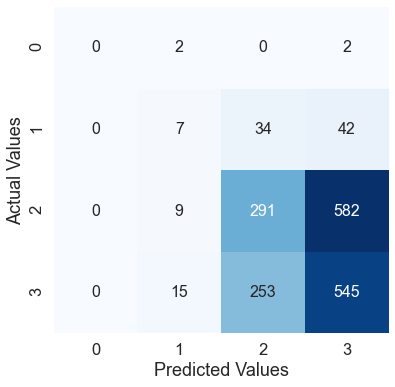

In [16]:
tic = datetime.now()

compile_train(vanilaLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model,X_test_scalled,Y_test))

Eye Gaze only

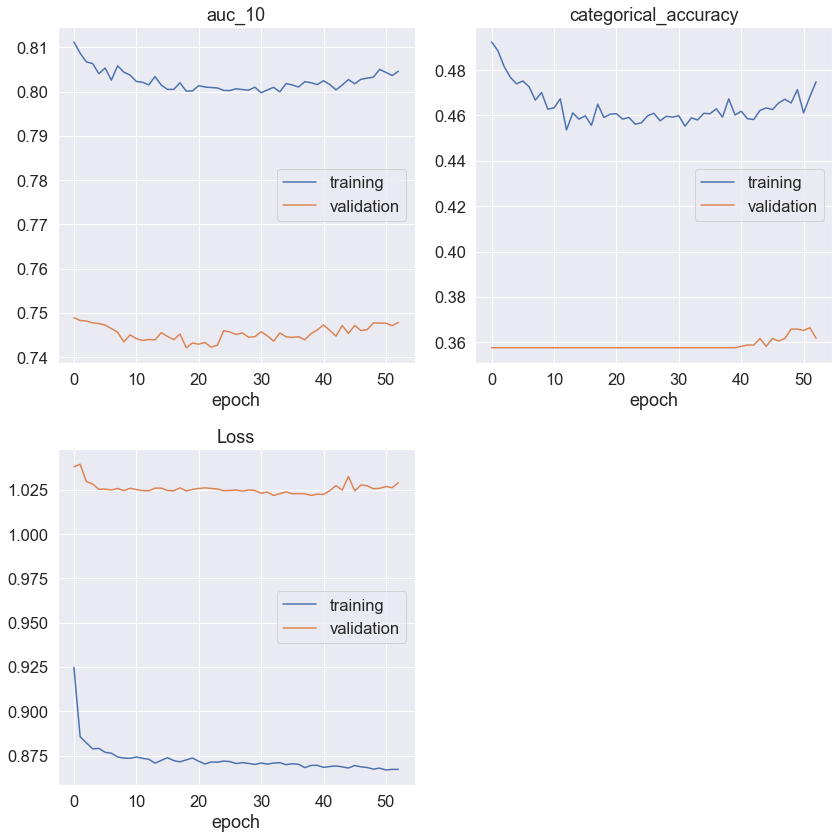

auc_10
	training         	 (min:    0.800, max:    0.811, cur:    0.805)
	validation       	 (min:    0.742, max:    0.749, cur:    0.748)
categorical_accuracy
	training         	 (min:    0.454, max:    0.492, cur:    0.475)
	validation       	 (min:    0.358, max:    0.366, cur:    0.362)
Loss
	training         	 (min:    0.867, max:    0.925, cur:    0.867)
	validation       	 (min:    1.022, max:    1.039, cur:    1.029)
5467/5467 [==============================] - 1s 198us/sample - loss: 0.8672 - categorical_accuracy: 0.4748 - auc_10: 0.8046 - val_loss: 1.0290 - val_categorical_accuracy: 0.3617 - val_auc_10: 0.7478
Training time:0:00:58.545599
1782/1782 [==============================] - 0s 71us/sample - loss: 0.8668 - categorical_accuracy: 0.4596 - auc_10: 0.8003
Accuracy on Test set: 45.96%
|vanilaLSTM|
 Error rate = 0.5404040404040404 
 MSE =  0.6930415263748597 
 Accuracy =  0.4595959595959596 
 AUC =  0.4922750942674356 
 F1-score =  0.1615180731233421 
 Fbeta =  0.2356580778

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


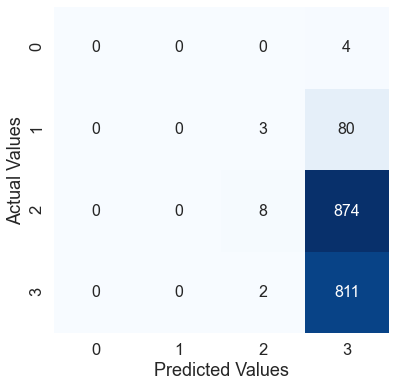

In [23]:
tic = datetime.now()

compile_train(vanilaLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_feat,X_test_eye,Y_test))

Head Pose only

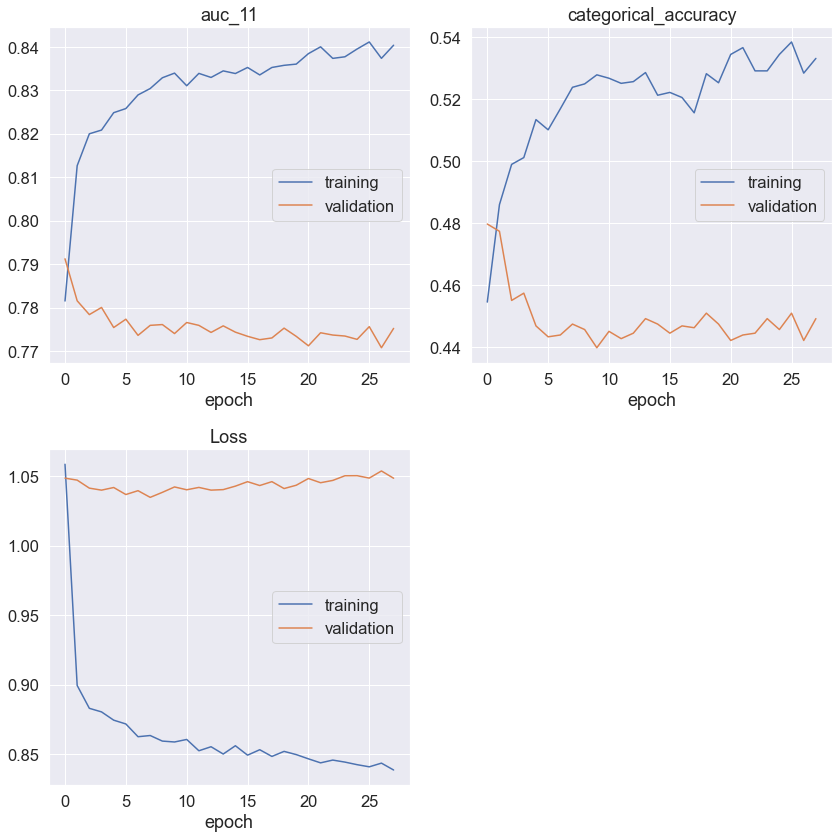

auc_11
	training         	 (min:    0.782, max:    0.841, cur:    0.840)
	validation       	 (min:    0.771, max:    0.791, cur:    0.775)
categorical_accuracy
	training         	 (min:    0.455, max:    0.539, cur:    0.533)
	validation       	 (min:    0.440, max:    0.480, cur:    0.449)
Loss
	training         	 (min:    0.839, max:    1.059, cur:    0.839)
	validation       	 (min:    1.035, max:    1.054, cur:    1.049)
5467/5467 [==============================] - 1s 202us/sample - loss: 0.8386 - categorical_accuracy: 0.5332 - auc_11: 0.8404 - val_loss: 1.0486 - val_categorical_accuracy: 0.4492 - val_auc_11: 0.7752
Training time:0:00:32.048283
1782/1782 [==============================] - 0s 75us/sample - loss: 0.8948 - categorical_accuracy: 0.4691 - auc_11: 0.8046
Accuracy on Test set: 46.91%
|vanilaLSTM|
 Error rate = 0.5308641975308642 
 MSE =  0.6268237934904601 
 Accuracy =  0.4691358024691358 
 AUC =  0.5215502167449968 
 F1-score =  0.24057686574580145 
 Fbeta =  0.246174083

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


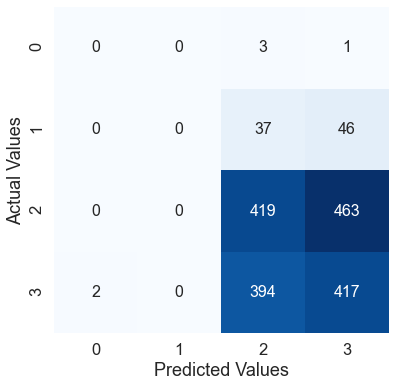

In [24]:
tic = datetime.now()

compile_train(vanilaLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_feat,X_test_head,Y_test))

AU only

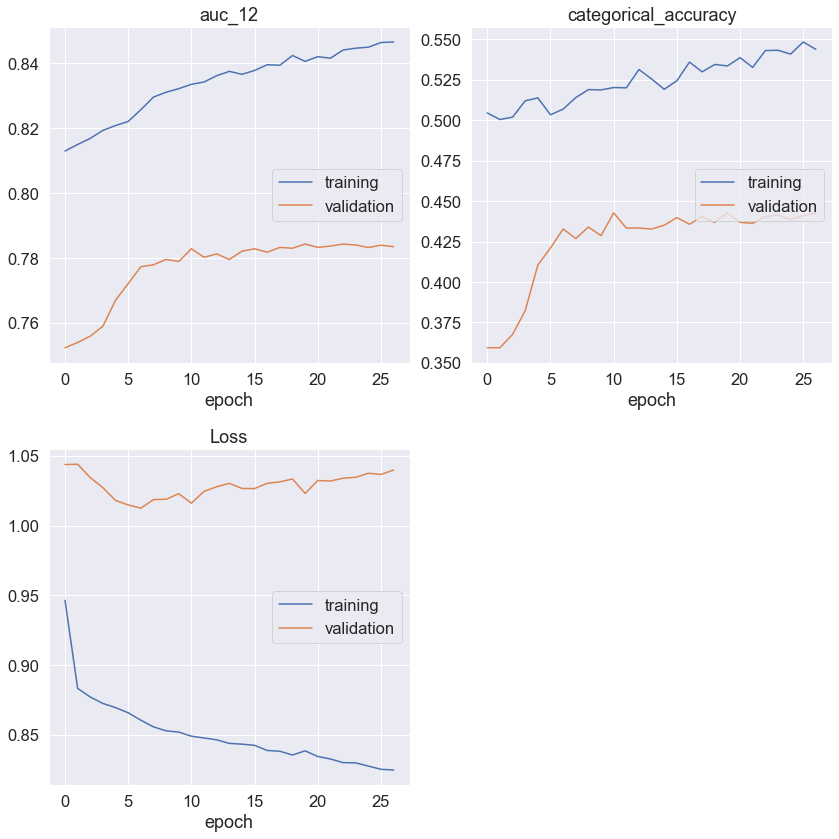

auc_12
	training         	 (min:    0.813, max:    0.847, cur:    0.847)
	validation       	 (min:    0.752, max:    0.784, cur:    0.783)
categorical_accuracy
	training         	 (min:    0.500, max:    0.548, cur:    0.544)
	validation       	 (min:    0.359, max:    0.443, cur:    0.443)
Loss
	training         	 (min:    0.825, max:    0.946, cur:    0.825)
	validation       	 (min:    1.012, max:    1.044, cur:    1.040)
5467/5467 [==============================] - 1s 197us/sample - loss: 0.8248 - categorical_accuracy: 0.5438 - auc_12: 0.8465 - val_loss: 1.0399 - val_categorical_accuracy: 0.4427 - val_auc_12: 0.7835
Training time:0:00:30.608684
1782/1782 [==============================] - 0s 71us/sample - loss: 0.8964 - categorical_accuracy: 0.4714 - auc_12: 0.8077
Accuracy on Test set: 47.14%
|vanilaLSTM|
 Error rate = 0.5286195286195287 
 MSE =  0.622895622895623 
 Accuracy =  0.4713804713804714 
 AUC =  0.5578394636804563 
 F1-score =  0.2425206542243502 
 Fbeta =  0.25412941725

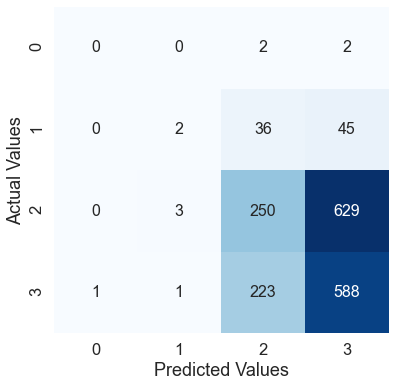

In [25]:
tic = datetime.now()

compile_train(vanilaLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = vanilaLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(vanilaLSTM_model_au,X_test_au,Y_test))

## 2. Stacked LSTM

No feature selection  (329 dimensions)

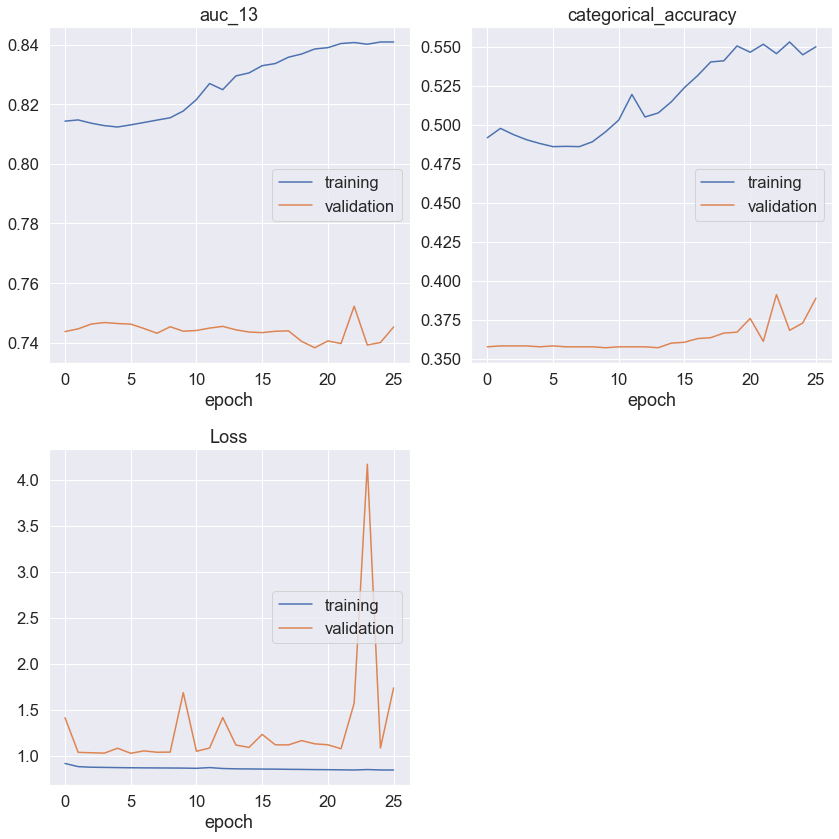

auc_13
	training         	 (min:    0.812, max:    0.841, cur:    0.841)
	validation       	 (min:    0.738, max:    0.752, cur:    0.745)
categorical_accuracy
	training         	 (min:    0.486, max:    0.553, cur:    0.550)
	validation       	 (min:    0.357, max:    0.391, cur:    0.389)
Loss
	training         	 (min:    0.847, max:    0.918, cur:    0.847)
	validation       	 (min:    1.028, max:    4.170, cur:    1.739)
5467/5467 [==============================] - 3s 597us/sample - loss: 0.8466 - categorical_accuracy: 0.5500 - auc_13: 0.8409 - val_loss: 1.7391 - val_categorical_accuracy: 0.3887 - val_auc_13: 0.7452
Training time:0:01:32.847014
1782/1782 [==============================] - 0s 186us/sample - loss: 0.9018 - categorical_accuracy: 0.4691 - auc_13: 0.8025
Accuracy on Test set: 46.91%
|stackedLSTM|
 Error rate = 0.5308641975308642 
 MSE =  0.6655443322109988 
 Accuracy =  0.4691358024691358 
 AUC =  0.5470266335824081 
 F1-score =  0.21302911320024764 
 Fbeta =  0.2453571

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


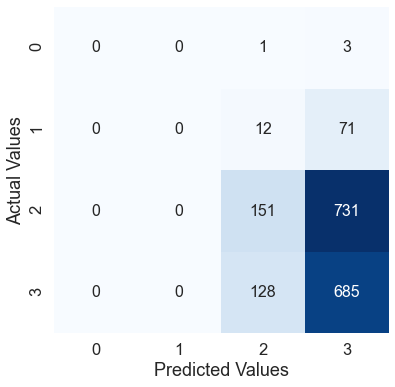

In [26]:
tic = datetime.now()

compile_train(stackedLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model_all,X_test_all_scalled, Y_test))

EHA (non-scalled)

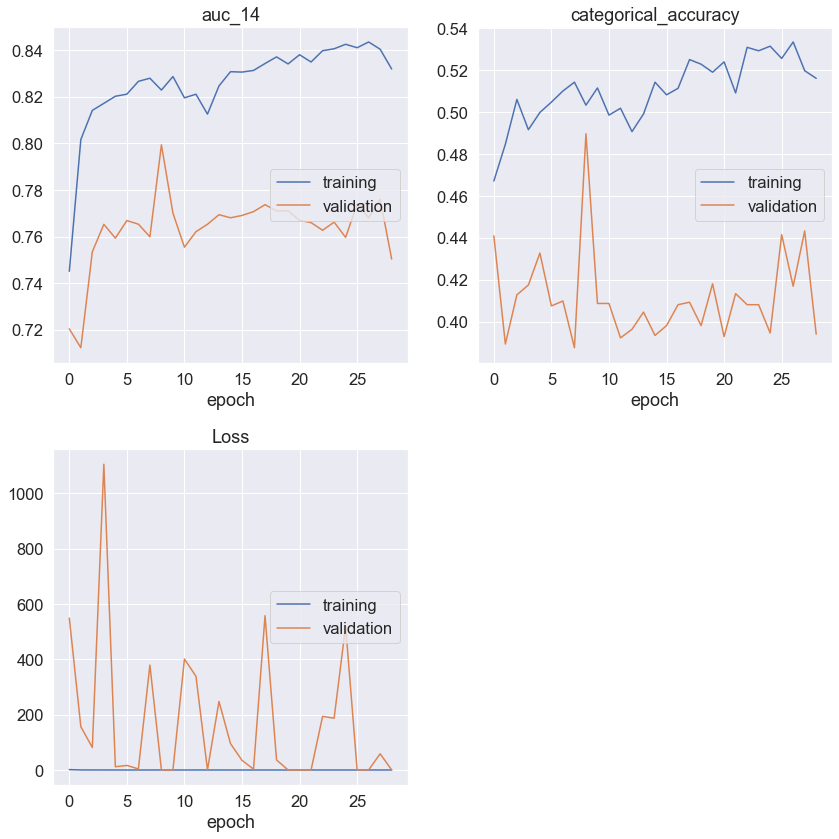

auc_14
	training         	 (min:    0.745, max:    0.844, cur:    0.832)
	validation       	 (min:    0.712, max:    0.799, cur:    0.750)
categorical_accuracy
	training         	 (min:    0.467, max:    0.534, cur:    0.516)
	validation       	 (min:    0.388, max:    0.490, cur:    0.394)
Loss
	training         	 (min:    0.826, max:    2.296, cur:    0.866)
	validation       	 (min:    1.006, max: 1104.955, cur:    1.144)
5467/5467 [==============================] - 3s 587us/sample - loss: 0.8664 - categorical_accuracy: 0.5162 - auc_14: 0.8319 - val_loss: 1.1440 - val_categorical_accuracy: 0.3940 - val_auc_14: 0.7504
Training time:0:01:43.170711
1782/1782 [==============================] - 0s 163us/sample - loss: 1.0119 - categorical_accuracy: 0.4978 - auc_14: 0.8008
Accuracy on Test set: 49.78%
|stackedLSTM|
 Error rate = 0.5022446689113356 
 MSE =  0.6397306397306397 
 Accuracy =  0.49775533108866443 
 AUC =  0.4974776361294828 
 F1-score =  0.2368373141975522 
 Fbeta =  0.2611449

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


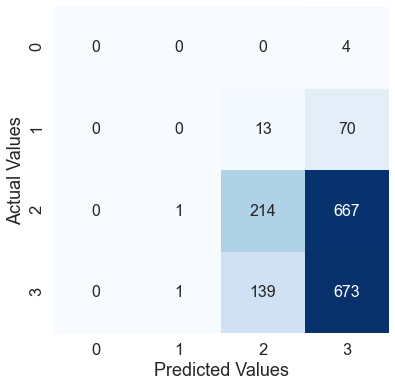

In [27]:
tic = datetime.now()

compile_train(stackedLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(stackedLSTM_model,X_test, Y_test))

EHA (scalled)

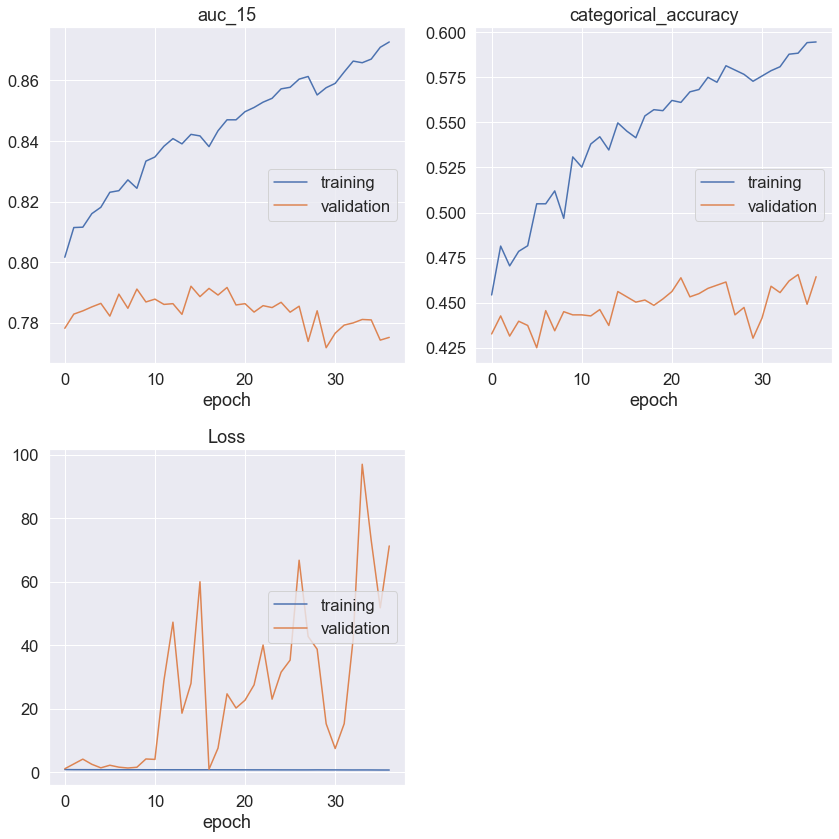

auc_15
	training         	 (min:    0.802, max:    0.873, cur:    0.873)
	validation       	 (min:    0.772, max:    0.792, cur:    0.775)
categorical_accuracy
	training         	 (min:    0.454, max:    0.594, cur:    0.594)
	validation       	 (min:    0.425, max:    0.466, cur:    0.464)
Loss
	training         	 (min:    0.762, max:    0.907, cur:    0.762)
	validation       	 (min:    0.995, max:   96.962, cur:   71.257)
5467/5467 [==============================] - 4s 660us/sample - loss: 0.7620 - categorical_accuracy: 0.5945 - auc_15: 0.8727 - val_loss: 71.2573 - val_categorical_accuracy: 0.4645 - val_auc_15: 0.7752
Training time:0:02:08.857776
1782/1782 [==============================] - 0s 177us/sample - loss: 1.0178 - categorical_accuracy: 0.4826 - auc_15: 0.8062
Accuracy on Test set: 48.26%
|stackedLSTM|
 Error rate = 0.5173961840628507 
 MSE =  0.6526374859708193 
 Accuracy =  0.4826038159371493 
 AUC =  0.48699373415796426 
 F1-score =  0.255071967633421 
 Fbeta =  0.2568597

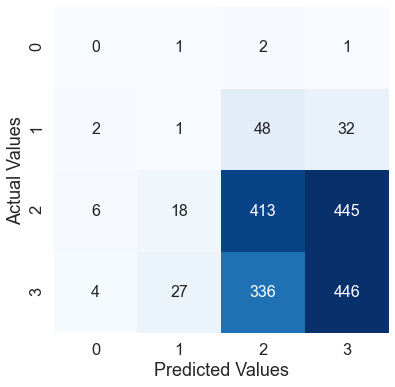

In [28]:
tic = datetime.now()

compile_train(stackedLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model,X_test_scalled,Y_test))

Eye Gaze only

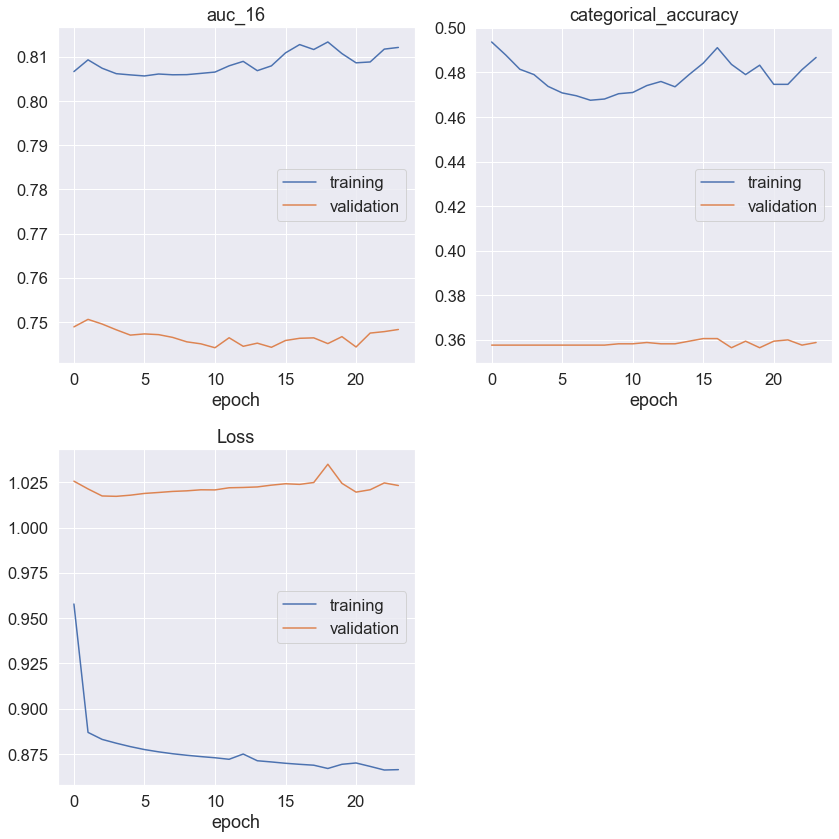

auc_16
	training         	 (min:    0.806, max:    0.813, cur:    0.812)
	validation       	 (min:    0.744, max:    0.751, cur:    0.748)
categorical_accuracy
	training         	 (min:    0.468, max:    0.494, cur:    0.487)
	validation       	 (min:    0.356, max:    0.361, cur:    0.359)
Loss
	training         	 (min:    0.866, max:    0.958, cur:    0.866)
	validation       	 (min:    1.017, max:    1.035, cur:    1.023)
5467/5467 [==============================] - 3s 638us/sample - loss: 0.8664 - categorical_accuracy: 0.4867 - auc_16: 0.8121 - val_loss: 1.0233 - val_categorical_accuracy: 0.3588 - val_auc_16: 0.7483
Training time:0:01:23.154069
1782/1782 [==============================] - 0s 171us/sample - loss: 0.8756 - categorical_accuracy: 0.4534 - auc_16: 0.7996
Accuracy on Test set: 45.34%


c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|stackedLSTM|
 Error rate = 0.5465768799102132 
 MSE =  0.6907968574635241 
 Accuracy =  0.45342312008978675 
 AUC =  0.5777212525088213 
 F1-score =  0.17516160413236104 
 Fbeta =  0.2341687211988826
None


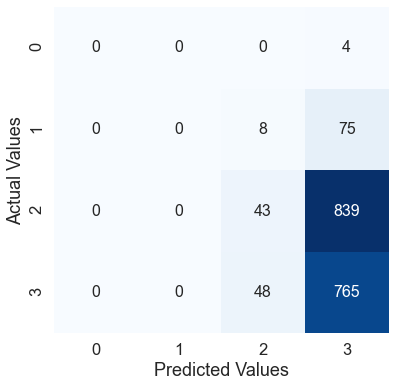

In [29]:
tic = datetime.now()

compile_train(stackedLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_feat,X_test_eye,Y_test))

Head Pose only

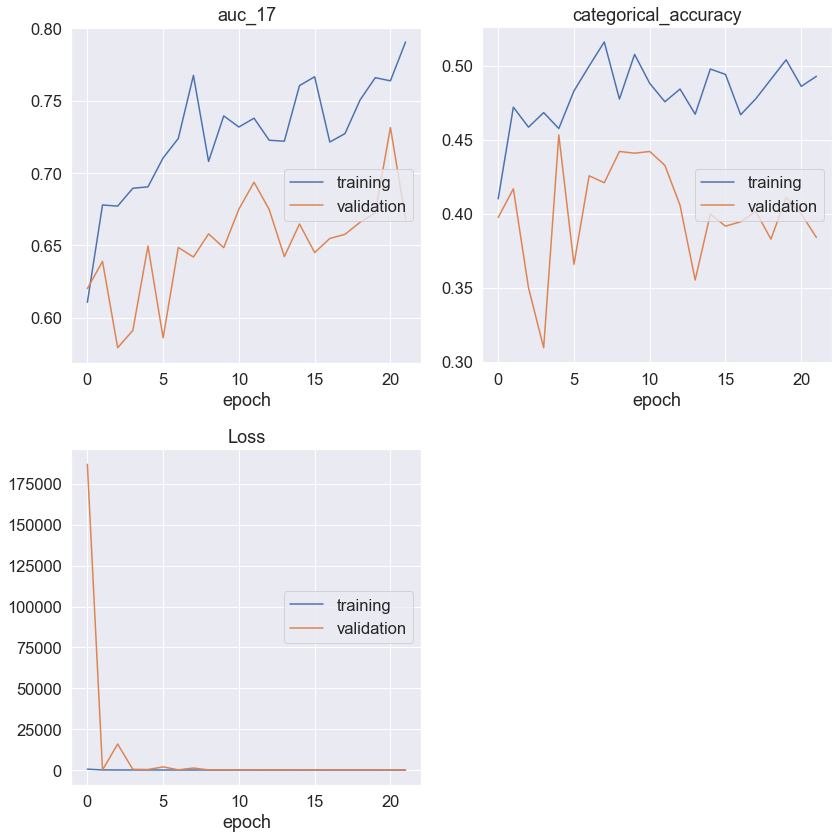

auc_17
	training         	 (min:    0.611, max:    0.791, cur:    0.791)
	validation       	 (min:    0.579, max:    0.731, cur:    0.668)
categorical_accuracy
	training         	 (min:    0.410, max:    0.516, cur:    0.493)
	validation       	 (min:    0.309, max:    0.453, cur:    0.384)
Loss
	training         	 (min:    1.518, max:  526.336, cur:    1.518)
	validation       	 (min:   34.196, max: 187038.759, cur:   47.948)
5467/5467 [==============================] - 4s 663us/sample - loss: 1.5179 - categorical_accuracy: 0.4930 - auc_17: 0.7906 - val_loss: 47.9478 - val_categorical_accuracy: 0.3840 - val_auc_17: 0.6684
Training time:0:01:17.447556
1782/1782 [==============================] - 0s 169us/sample - loss: 2.1601 - categorical_accuracy: 0.4635 - auc_17: 0.7084
Accuracy on Test set: 46.35%
|stackedLSTM|
 Error rate = 0.5364758698092031 
 MSE =  0.6857463524130191 
 Accuracy =  0.46352413019079686 
 AUC =  0.5305291464530444 
 F1-score =  0.18270198514966215 
 Fbeta =  0.239

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


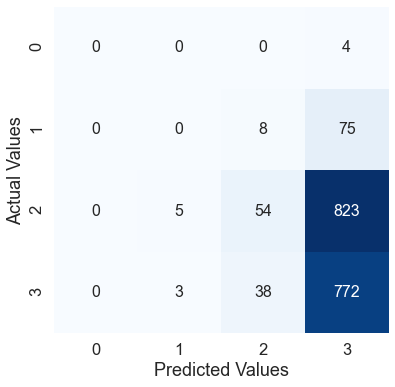

In [30]:
tic = datetime.now()

compile_train(stackedLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_feat,X_test_head,Y_test))

AU only

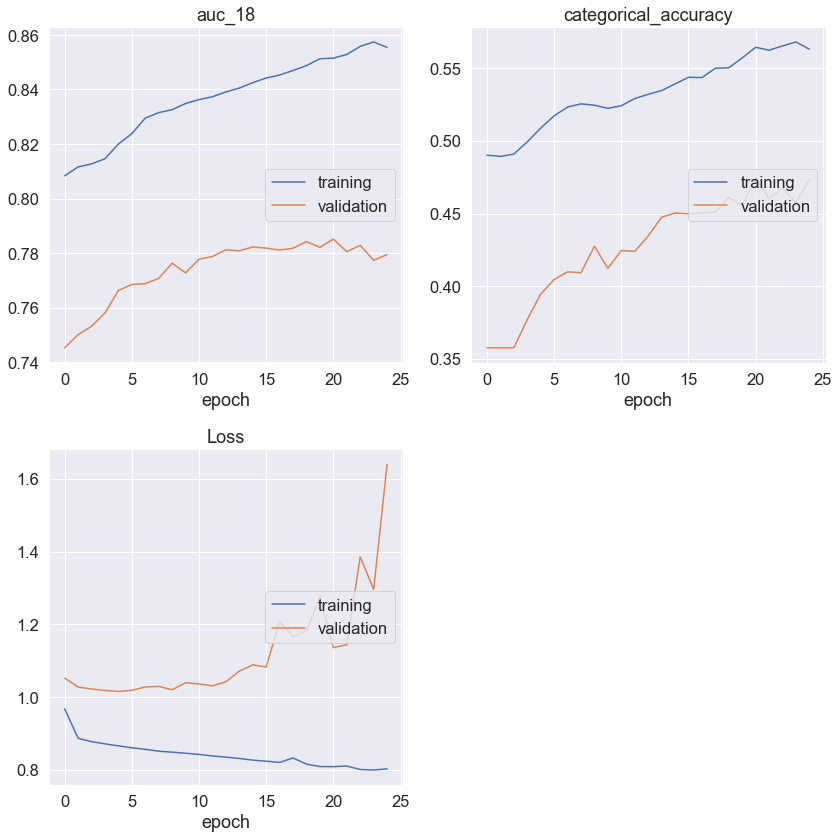

auc_18
	training         	 (min:    0.808, max:    0.857, cur:    0.855)
	validation       	 (min:    0.745, max:    0.785, cur:    0.779)
categorical_accuracy
	training         	 (min:    0.489, max:    0.568, cur:    0.563)
	validation       	 (min:    0.358, max:    0.474, cur:    0.473)
Loss
	training         	 (min:    0.800, max:    0.968, cur:    0.803)
	validation       	 (min:    1.016, max:    1.640, cur:    1.640)
5467/5467 [==============================] - 4s 733us/sample - loss: 0.8031 - categorical_accuracy: 0.5632 - auc_18: 0.8555 - val_loss: 1.6399 - val_categorical_accuracy: 0.4733 - val_auc_18: 0.7794
Training time:0:01:31.020105
1782/1782 [==============================] - 0s 179us/sample - loss: 1.1238 - categorical_accuracy: 0.4703 - auc_18: 0.8046
Accuracy on Test set: 47.03%
|stackedLSTM|
 Error rate = 0.5297418630751964 
 MSE =  0.6066217732884399 
 Accuracy =  0.4702581369248036 
 AUC =  0.4672390413091474 
 F1-score =  0.24021226170287857 
 Fbeta =  0.2508633

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


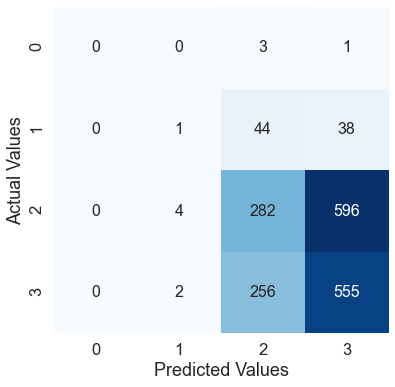

In [31]:
tic = datetime.now()

compile_train(stackedLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = stackedLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(stackedLSTM_model_au,X_test_au,Y_test))

## 3. biLSTM

No feature selection (329 dimensions)

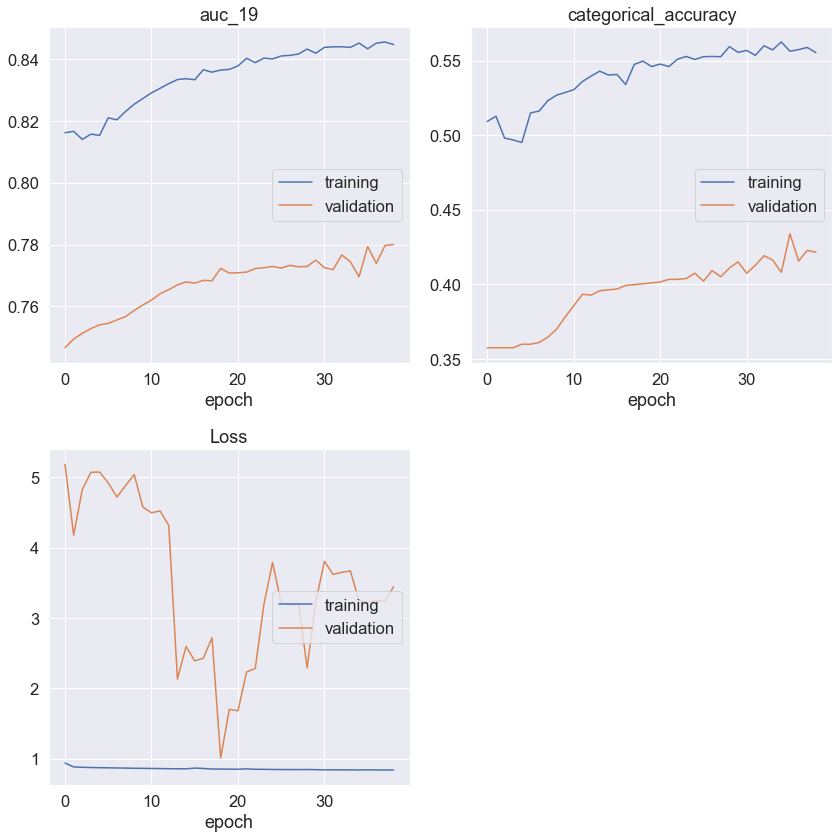

auc_19
	training         	 (min:    0.814, max:    0.846, cur:    0.845)
	validation       	 (min:    0.747, max:    0.780, cur:    0.780)
categorical_accuracy
	training         	 (min:    0.495, max:    0.562, cur:    0.555)
	validation       	 (min:    0.358, max:    0.434, cur:    0.422)
Loss
	training         	 (min:    0.839, max:    0.938, cur:    0.840)
	validation       	 (min:    1.011, max:    5.188, cur:    3.447)
5467/5467 [==============================] - 4s 650us/sample - loss: 0.8400 - categorical_accuracy: 0.5553 - auc_19: 0.8448 - val_loss: 3.4471 - val_categorical_accuracy: 0.4216 - val_auc_19: 0.7800
Training time:0:02:13.013786
1782/1782 [==============================] - 0s 166us/sample - loss: 0.8755 - categorical_accuracy: 0.4848 - auc_19: 0.8171
Accuracy on Test set: 48.48%
|biLSTM|
 Error rate = 0.5151515151515151 
 MSE =  0.6341189674523008 
 Accuracy =  0.48484848484848486 
 AUC =  0.5738778301278908 
 F1-score =  0.23321337391402955 
 Fbeta =  0.25718728362

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


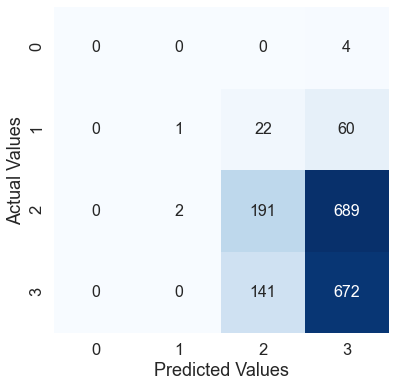

In [32]:
tic = datetime.now()

compile_train(biLSTM_model_all,X_train_all_scalled,Y_train_cat,X_val_all_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model_all,X_test_all_scalled, Y_test))

EHA (non-scalled)

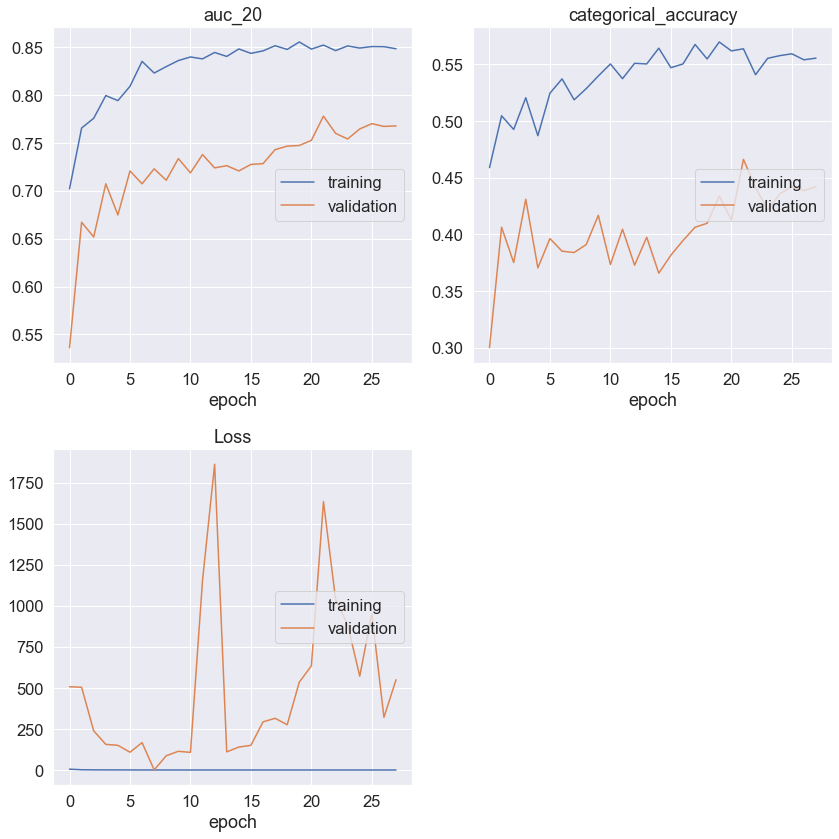

auc_20
	training         	 (min:    0.702, max:    0.856, cur:    0.848)
	validation       	 (min:    0.536, max:    0.778, cur:    0.768)
categorical_accuracy
	training         	 (min:    0.459, max:    0.570, cur:    0.556)
	validation       	 (min:    0.300, max:    0.466, cur:    0.442)
Loss
	training         	 (min:    0.832, max:    6.044, cur:    0.847)
	validation       	 (min:    1.353, max: 1861.865, cur:  550.295)
5467/5467 [==============================] - 3s 610us/sample - loss: 0.8467 - categorical_accuracy: 0.5555 - auc_20: 0.8485 - val_loss: 550.2950 - val_categorical_accuracy: 0.4422 - val_auc_20: 0.7679
Training time:0:01:38.515404
1782/1782 [==============================] - 0s 160us/sample - loss: 0.9710 - categorical_accuracy: 0.4624 - auc_20: 0.7972
Accuracy on Test set: 46.24%
|biLSTM|
 Error rate = 0.5375982042648709 
 MSE =  0.6537598204264871 
 Accuracy =  0.4624017957351291 
 AUC =  0.4690618238065929 
 F1-score =  0.23590345004192803 
 Fbeta =  0.2466359564

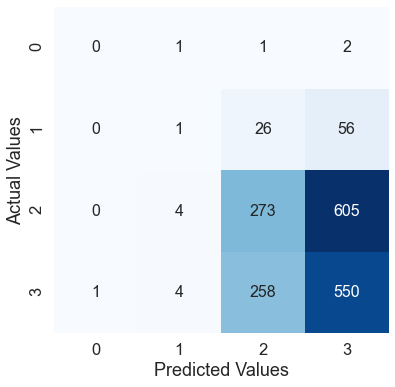

In [33]:
tic = datetime.now()

compile_train(biLSTM_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_model,X_test, Y_test))

EHA (scalled)

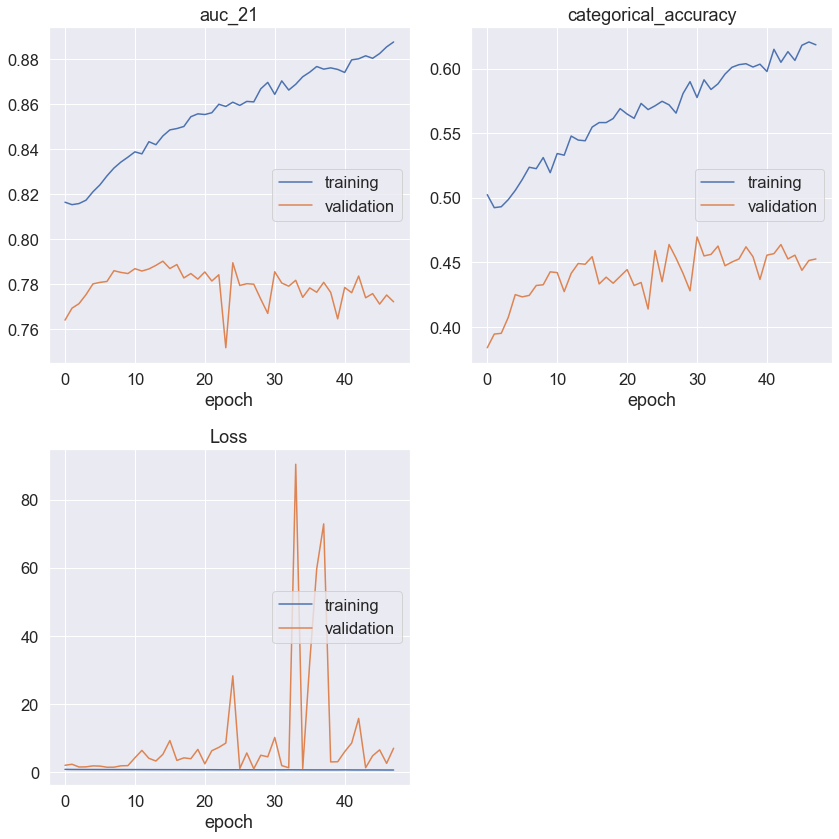

auc_21
	training         	 (min:    0.815, max:    0.888, cur:    0.888)
	validation       	 (min:    0.752, max:    0.790, cur:    0.772)
categorical_accuracy
	training         	 (min:    0.492, max:    0.621, cur:    0.618)
	validation       	 (min:    0.384, max:    0.470, cur:    0.453)
Loss
	training         	 (min:    0.721, max:    0.907, cur:    0.721)
	validation       	 (min:    1.090, max:   90.341, cur:    7.103)
5467/5467 [==============================] - 5s 866us/sample - loss: 0.7210 - categorical_accuracy: 0.6184 - auc_21: 0.8876 - val_loss: 7.1026 - val_categorical_accuracy: 0.4527 - val_auc_21: 0.7722
Training time:0:02:50.332216
1782/1782 [==============================] - 1s 285us/sample - loss: 1.3190 - categorical_accuracy: 0.4501 - auc_21: 0.7816
Accuracy on Test set: 45.01%
|biLSTM|
 Error rate = 0.5499438832772167 
 MSE =  0.7373737373737373 
 Accuracy =  0.4500561167227834 
 AUC =  0.4387543829799871 
 F1-score =  0.2422286844558247 
 Fbeta =  0.2431219163936

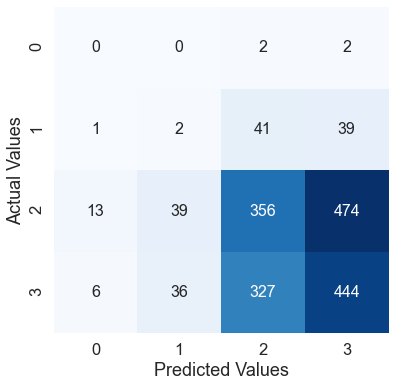

In [34]:
tic = datetime.now()

compile_train(biLSTM_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model,X_test_scalled,Y_test))

Eye Gaze only

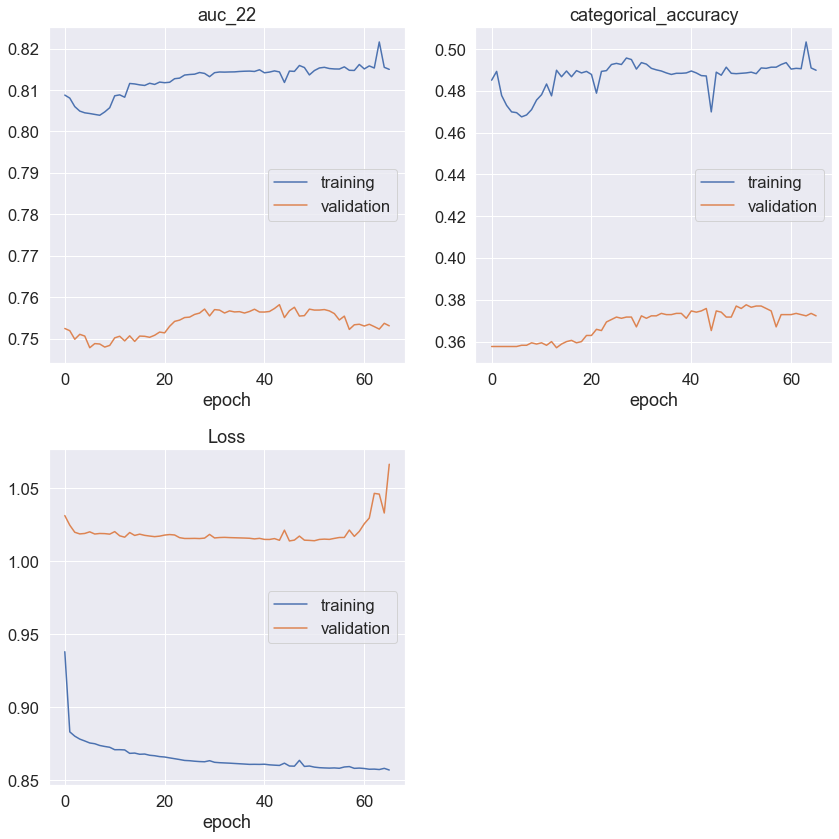

auc_22
	training         	 (min:    0.804, max:    0.822, cur:    0.815)
	validation       	 (min:    0.748, max:    0.758, cur:    0.753)
categorical_accuracy
	training         	 (min:    0.468, max:    0.503, cur:    0.490)
	validation       	 (min:    0.357, max:    0.378, cur:    0.372)
Loss
	training         	 (min:    0.857, max:    0.938, cur:    0.857)
	validation       	 (min:    1.014, max:    1.066, cur:    1.066)
5467/5467 [==============================] - 4s 681us/sample - loss: 0.8570 - categorical_accuracy: 0.4898 - auc_22: 0.8150 - val_loss: 1.0665 - val_categorical_accuracy: 0.3723 - val_auc_22: 0.7531
Training time:0:03:58.507664
1782/1782 [==============================] - 0s 165us/sample - loss: 0.8678 - categorical_accuracy: 0.4534 - auc_22: 0.8036
Accuracy on Test set: 45.34%
|biLSTM|
 Error rate = 0.5465768799102132 
 MSE =  0.6829405162738497 
 Accuracy =  0.45342312008978675 
 AUC =  0.5575515360761881 
 F1-score =  0.1815968526395555 
 Fbeta =  0.234848152668

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


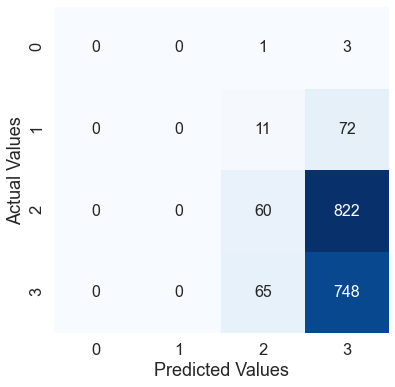

In [35]:
tic = datetime.now()

compile_train(biLSTM_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_feat,X_test_eye,Y_test))

Head Pose only

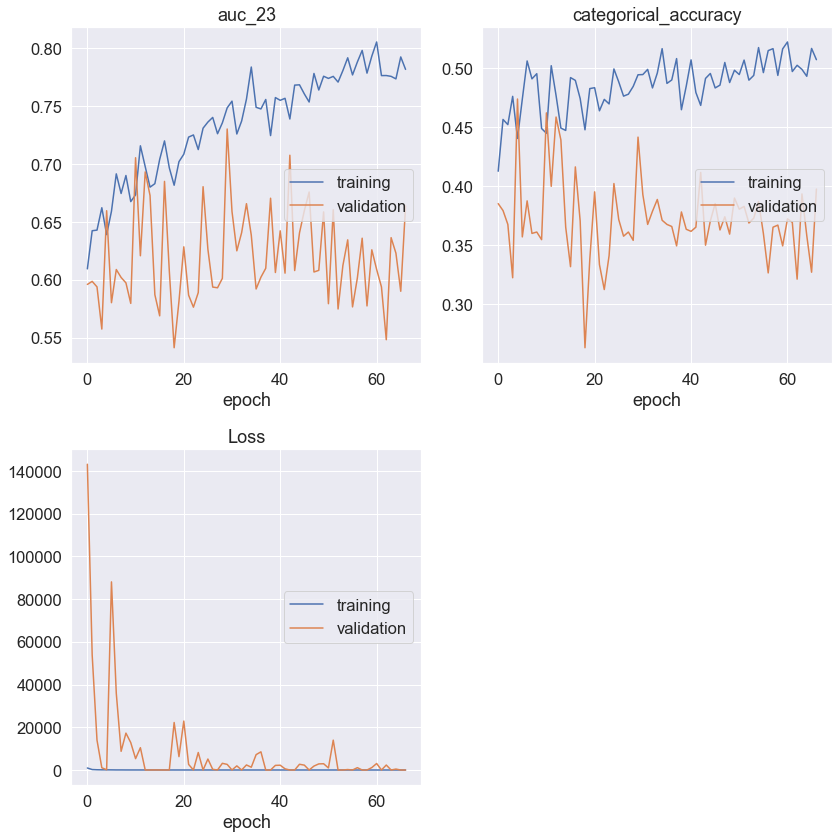

auc_23
	training         	 (min:    0.610, max:    0.805, cur:    0.782)
	validation       	 (min:    0.541, max:    0.730, cur:    0.664)
categorical_accuracy
	training         	 (min:    0.413, max:    0.522, cur:    0.507)
	validation       	 (min:    0.263, max:    0.474, cur:    0.398)
Loss
	training         	 (min:    1.754, max:  946.374, cur:    2.076)
	validation       	 (min:    3.106, max: 143177.221, cur:    3.355)
5467/5467 [==============================] - 3s 630us/sample - loss: 2.0760 - categorical_accuracy: 0.5072 - auc_23: 0.7817 - val_loss: 3.3545 - val_categorical_accuracy: 0.3975 - val_auc_23: 0.6639
Training time:0:03:56.743711
1782/1782 [==============================] - 0s 163us/sample - loss: 3.0372 - categorical_accuracy: 0.4630 - auc_23: 0.7017
Accuracy on Test set: 46.30%
|biLSTM|
 Error rate = 0.5370370370370371 
 MSE =  0.6902356902356902 
 Accuracy =  0.46296296296296297 
 AUC =  0.4716805665511305 
 F1-score =  0.18231773533256568 
 Fbeta =  0.239350644

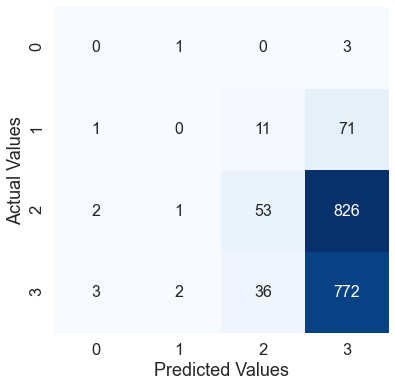

In [36]:
tic = datetime.now()

compile_train(biLSTM_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_feat,X_test_head,Y_test))

AU only

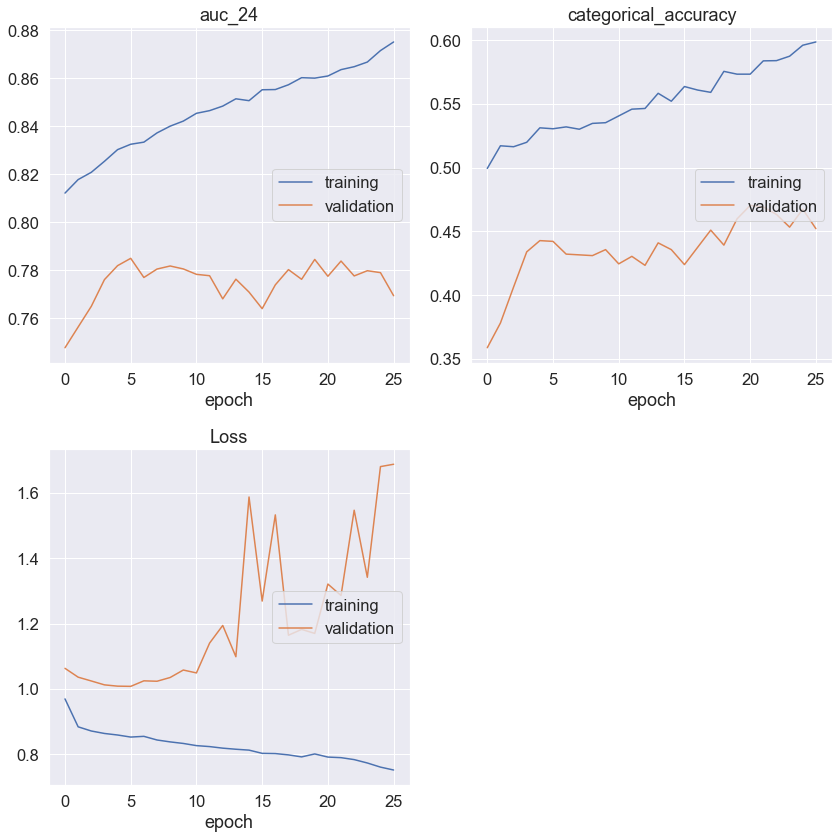

auc_24
	training         	 (min:    0.812, max:    0.875, cur:    0.875)
	validation       	 (min:    0.748, max:    0.785, cur:    0.769)
categorical_accuracy
	training         	 (min:    0.499, max:    0.599, cur:    0.599)
	validation       	 (min:    0.359, max:    0.470, cur:    0.452)
Loss
	training         	 (min:    0.752, max:    0.970, cur:    0.752)
	validation       	 (min:    1.008, max:    1.687, cur:    1.687)
5467/5467 [==============================] - 3s 600us/sample - loss: 0.7521 - categorical_accuracy: 0.5985 - auc_24: 0.8751 - val_loss: 1.6874 - val_categorical_accuracy: 0.4521 - val_auc_24: 0.7695
Training time:0:01:25.970671
1782/1782 [==============================] - 0s 164us/sample - loss: 1.1700 - categorical_accuracy: 0.4804 - auc_24: 0.8046
Accuracy on Test set: 48.04%
|biLSTM|
 Error rate = 0.5196408529741863 
 MSE =  0.6094276094276094 
 Accuracy =  0.48035914702581367 
 AUC =  0.46471409714116696 
 F1-score =  0.25385850558297973 
 Fbeta =  0.2618585656

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


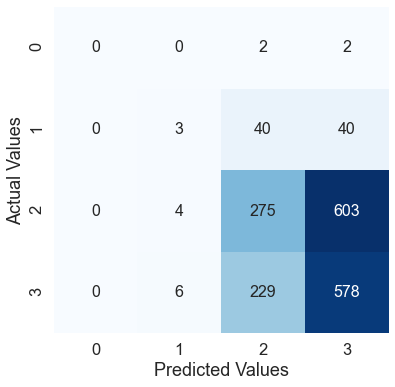

In [37]:
tic = datetime.now()

compile_train(biLSTM_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_model_au,X_test_au,Y_test))

## 4. BiLSTM Ensamble

No feature selection  (329 dimensions)

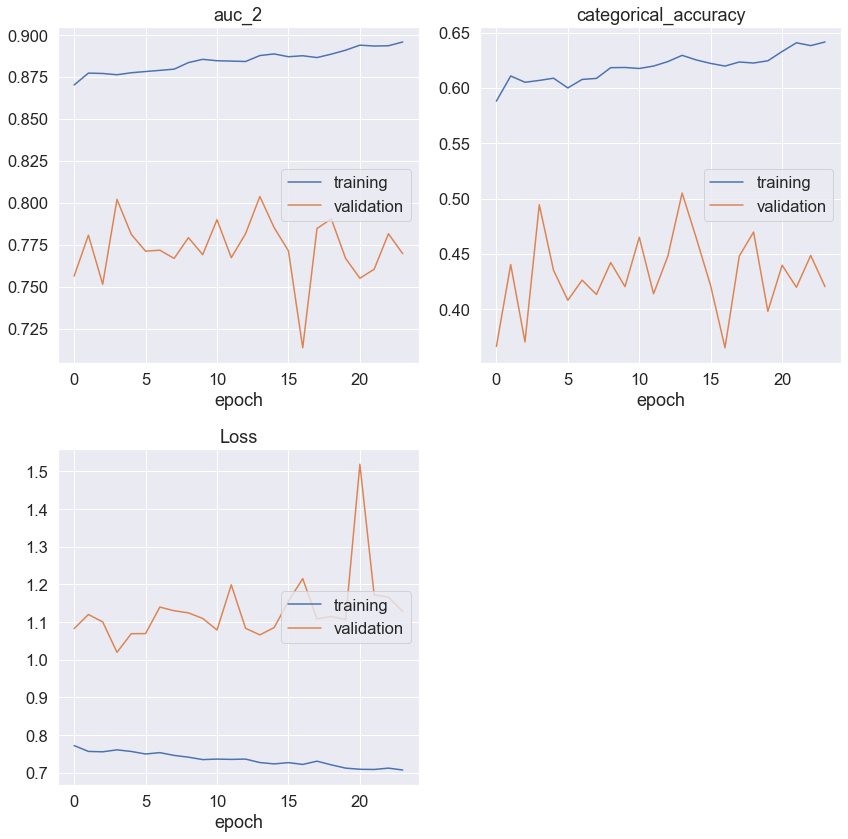

auc_2
	training         	 (min:    0.870, max:    0.896, cur:    0.896)
	validation       	 (min:    0.714, max:    0.804, cur:    0.770)
categorical_accuracy
	training         	 (min:    0.588, max:    0.641, cur:    0.641)
	validation       	 (min:    0.365, max:    0.505, cur:    0.420)
Loss
	training         	 (min:    0.707, max:    0.772, cur:    0.707)
	validation       	 (min:    1.020, max:    1.519, cur:    1.128)
5467/5467 [==============================] - 2s 294us/sample - loss: 0.7072 - categorical_accuracy: 0.6415 - auc_2: 0.8959 - val_loss: 1.1281 - val_categorical_accuracy: 0.4204 - val_auc_2: 0.7696
Training time:0:00:41.020712
1782/1782 [==============================] - 0s 101us/sample - loss: 1.0286 - categorical_accuracy: 0.5011 - auc_2: 0.8097
Accuracy on Test set: 50.11%
|biLSTM_en|
 Error rate = 0.4988776655443322 
 MSE =  0.6565656565656566 
 Accuracy =  0.5011223344556678 
 AUC =  0.5895480352193062 
 F1-score =  0.3133540465162825 
 Fbeta =  0.31567093064152

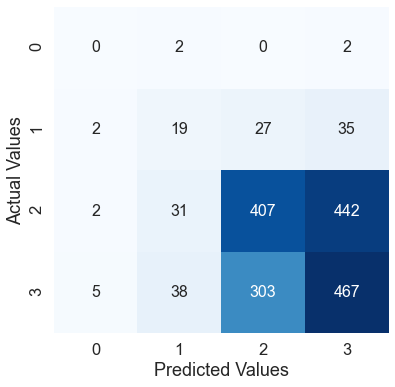

In [12]:
tic = datetime.now()

compile_train(biLSTM_en_model_all, X_train_all_scalled, Y_train_cat, X_val_all_scalled, Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_all.evaluate(X_test_all_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_all,X_test_all_scalled, Y_test))

EHA (scalled)

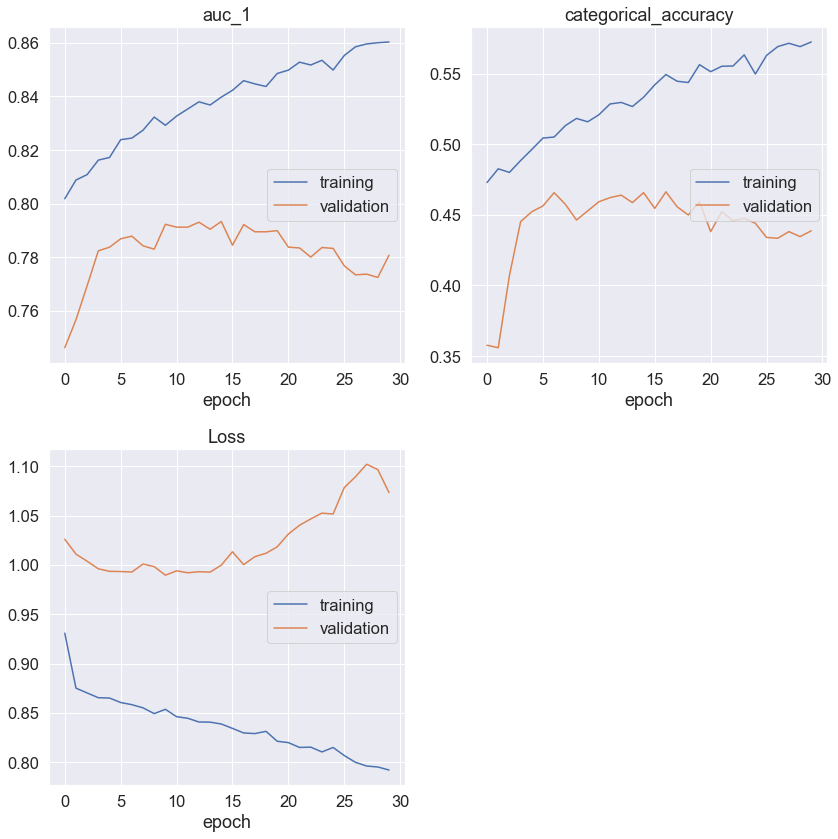

auc_1
	training         	 (min:    0.802, max:    0.860, cur:    0.860)
	validation       	 (min:    0.746, max:    0.793, cur:    0.781)
categorical_accuracy
	training         	 (min:    0.473, max:    0.572, cur:    0.572)
	validation       	 (min:    0.356, max:    0.466, cur:    0.439)
Loss
	training         	 (min:    0.792, max:    0.931, cur:    0.792)
	validation       	 (min:    0.990, max:    1.102, cur:    1.073)
5467/5467 [==============================] - 2s 302us/sample - loss: 0.7921 - categorical_accuracy: 0.5723 - auc_1: 0.8604 - val_loss: 1.0732 - val_categorical_accuracy: 0.4386 - val_auc_1: 0.7807
Training time:0:00:50.432961
1782/1782 [==============================] - 0s 104us/sample - loss: 0.9638 - categorical_accuracy: 0.4652 - auc_1: 0.7998
Accuracy on Test set: 46.52%
|biLSTM_en|
 Error rate = 0.5347923681257014 
 MSE =  0.6111111111111112 
 Accuracy =  0.46520763187429853 
 AUC =  0.5619861612364689 
 F1-score =  0.2399782496801078 
 Fbeta =  0.2448102406068

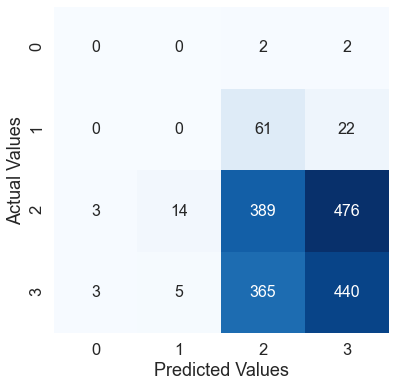

In [11]:
tic = datetime.now()

compile_train(biLSTM_en_model,X_train_scalled,Y_train_cat,X_val_scalled,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model.evaluate(X_test_scalled,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model,X_test_scalled,Y_test))

EHA (non-scalled)

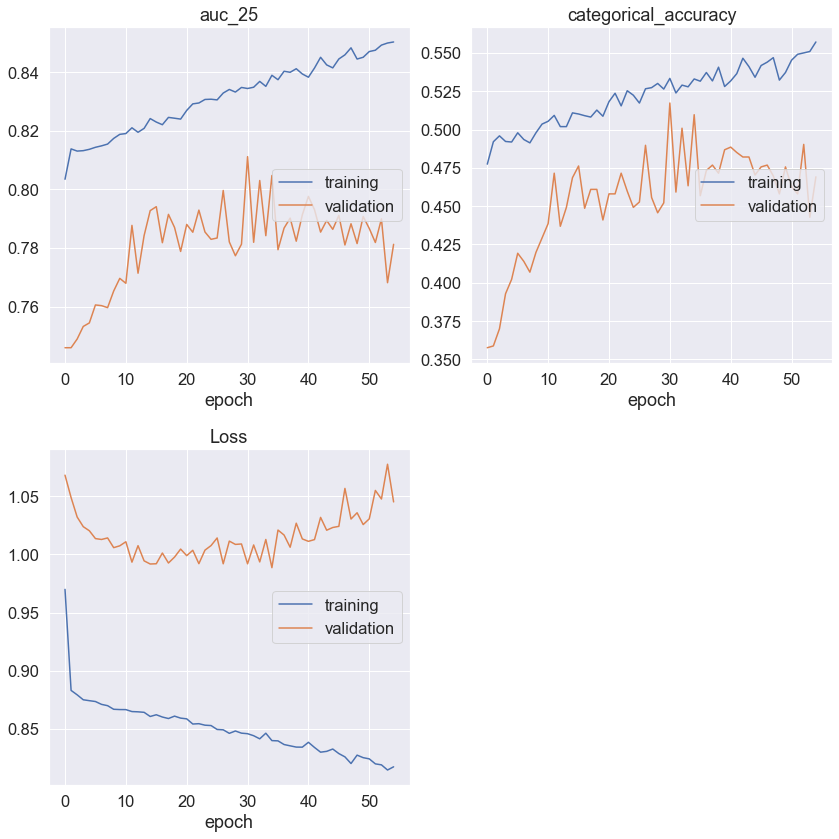

auc_25
	training         	 (min:    0.803, max:    0.850, cur:    0.850)
	validation       	 (min:    0.746, max:    0.811, cur:    0.781)
categorical_accuracy
	training         	 (min:    0.477, max:    0.557, cur:    0.557)
	validation       	 (min:    0.358, max:    0.517, cur:    0.469)
Loss
	training         	 (min:    0.815, max:    0.970, cur:    0.817)
	validation       	 (min:    0.989, max:    1.078, cur:    1.045)
5467/5467 [==============================] - 2s 294us/sample - loss: 0.8173 - categorical_accuracy: 0.5572 - auc_25: 0.8502 - val_loss: 1.0452 - val_categorical_accuracy: 0.4692 - val_auc_25: 0.7812
Training time:0:01:29.224559
1782/1782 [==============================] - 0s 102us/sample - loss: 0.9185 - categorical_accuracy: 0.4602 - auc_25: 0.8038
Accuracy on Test set: 46.02%
|biLSTM_en|
 Error rate = 0.5398428731762065 
 MSE =  0.6195286195286195 
 Accuracy =  0.4601571268237935 
 AUC =  0.5556011474244361 
 F1-score =  0.2338350714076308 
 Fbeta =  0.2425896364

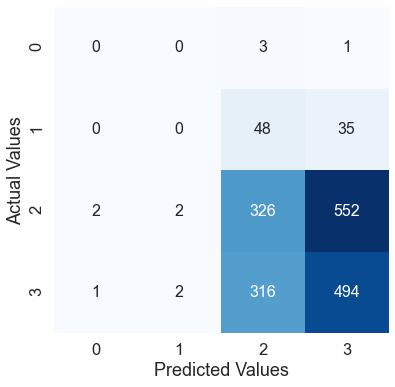

In [38]:
tic = datetime.now()

compile_train(biLSTM_en_model,X_train,Y_train_cat,X_val,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model.evaluate(X_test,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))

print(evaluate_error(biLSTM_en_model,X_test, Y_test))

Eye Gaze only

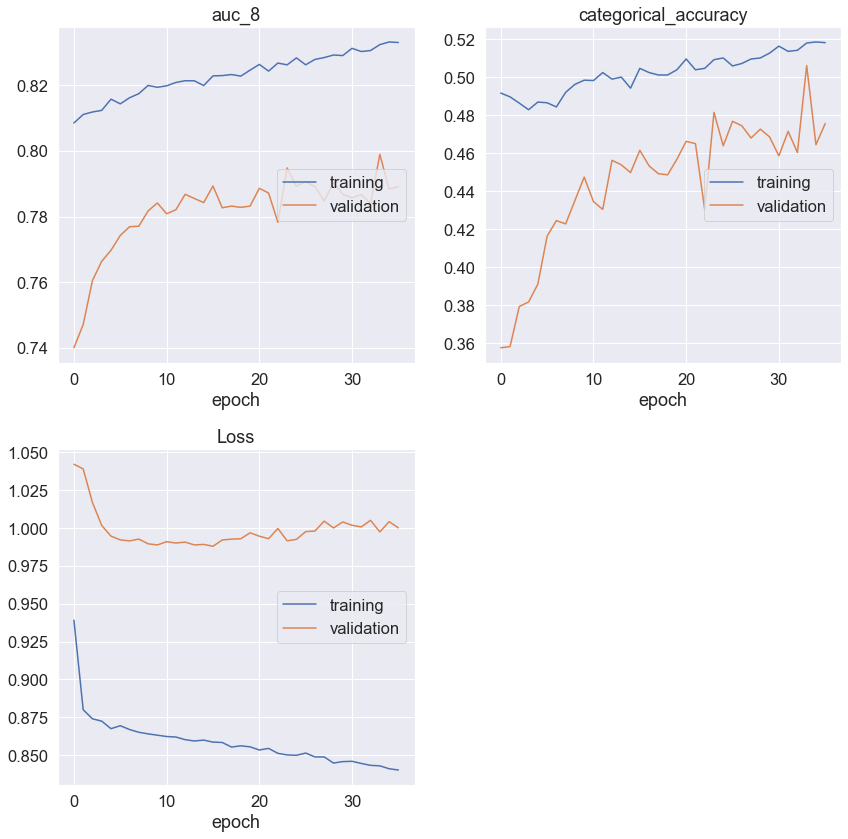

auc_8
	training         	 (min:    0.809, max:    0.833, cur:    0.833)
	validation       	 (min:    0.740, max:    0.799, cur:    0.789)
categorical_accuracy
	training         	 (min:    0.483, max:    0.519, cur:    0.518)
	validation       	 (min:    0.358, max:    0.506, cur:    0.476)
Loss
	training         	 (min:    0.840, max:    0.939, cur:    0.840)
	validation       	 (min:    0.988, max:    1.042, cur:    1.000)
5467/5467 [==============================] - 2s 281us/sample - loss: 0.8401 - categorical_accuracy: 0.5182 - auc_8: 0.8331 - val_loss: 1.0002 - val_categorical_accuracy: 0.4756 - val_auc_8: 0.7891
Training time:0:00:58.202238
1782/1782 [==============================] - 0s 91us/sample - loss: 0.9153 - categorical_accuracy: 0.4574 - auc_8: 0.8022
Accuracy on Test set: 45.74%
|biLSTM_en|
 Error rate = 0.542648709315376 
 MSE =  0.6122334455667789 
 Accuracy =  0.45735129068462405 
 AUC =  0.4925531599209927 
 F1-score =  0.23514137334102714 
 Fbeta =  0.24022587373572

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


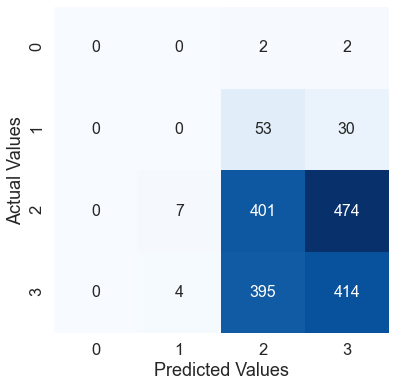

In [21]:
tic = datetime.now()

compile_train(biLSTM_en_model_feat,X_train_eye,Y_train_cat,X_val_eye,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_feat.evaluate(X_test_eye,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_feat,X_test_eye,Y_test))

Head Pose only

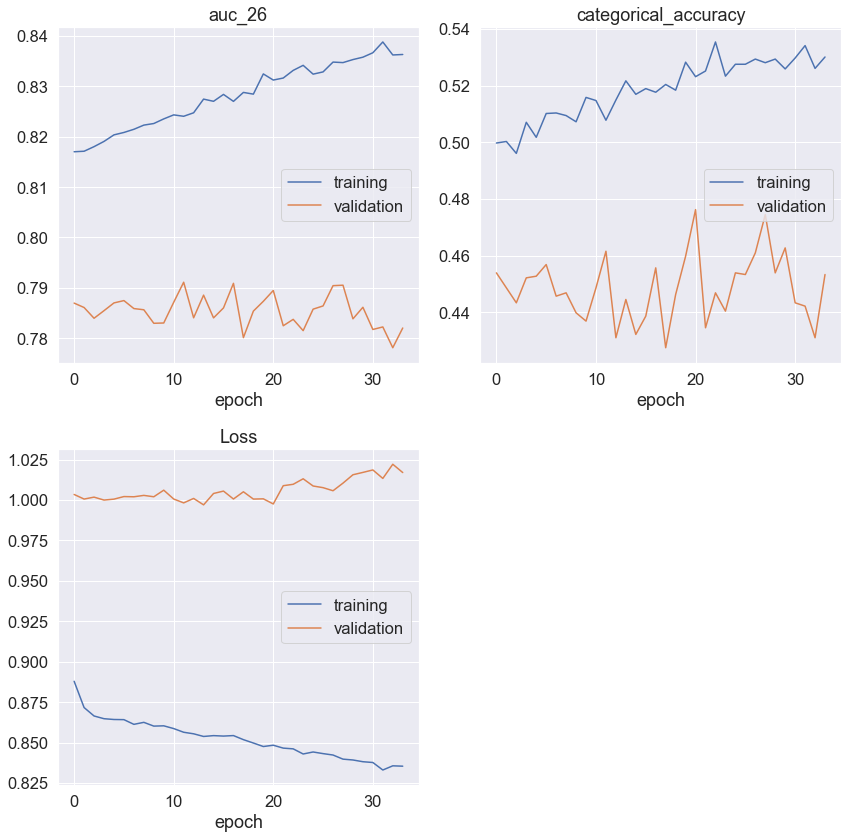

auc_26
	training         	 (min:    0.817, max:    0.839, cur:    0.836)
	validation       	 (min:    0.778, max:    0.791, cur:    0.782)
categorical_accuracy
	training         	 (min:    0.496, max:    0.535, cur:    0.530)
	validation       	 (min:    0.427, max:    0.476, cur:    0.453)
Loss
	training         	 (min:    0.833, max:    0.888, cur:    0.835)
	validation       	 (min:    0.997, max:    1.022, cur:    1.017)
5467/5467 [==============================] - 2s 282us/sample - loss: 0.8354 - categorical_accuracy: 0.5301 - auc_26: 0.8363 - val_loss: 1.0170 - val_categorical_accuracy: 0.4533 - val_auc_26: 0.7820
Training time:0:00:55.530463
1782/1782 [==============================] - 0s 96us/sample - loss: 0.8811 - categorical_accuracy: 0.4949 - auc_26: 0.8137
Accuracy on Test set: 49.49%
|biLSTM_en|
 Error rate = 0.5050505050505051 
 MSE =  0.6111111111111112 
 Accuracy =  0.494949494949495 
 AUC =  0.5516033765924561 
 F1-score =  0.24777176759405245 
 Fbeta =  0.26075294390

c:\Users\hasegawa-lab-pc\miniconda3\envs\tf2.1\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


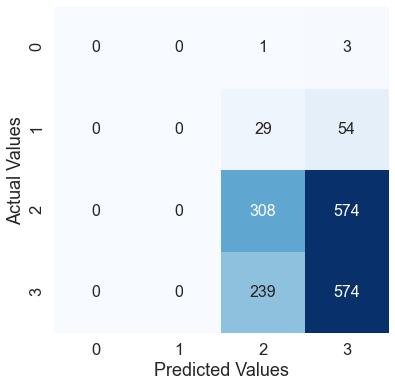

In [39]:
tic = datetime.now()

compile_train(biLSTM_en_model_feat,X_train_head,Y_train_cat,X_val_head,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_feat.evaluate(X_test_head,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_feat,X_test_head,Y_test))

AU only

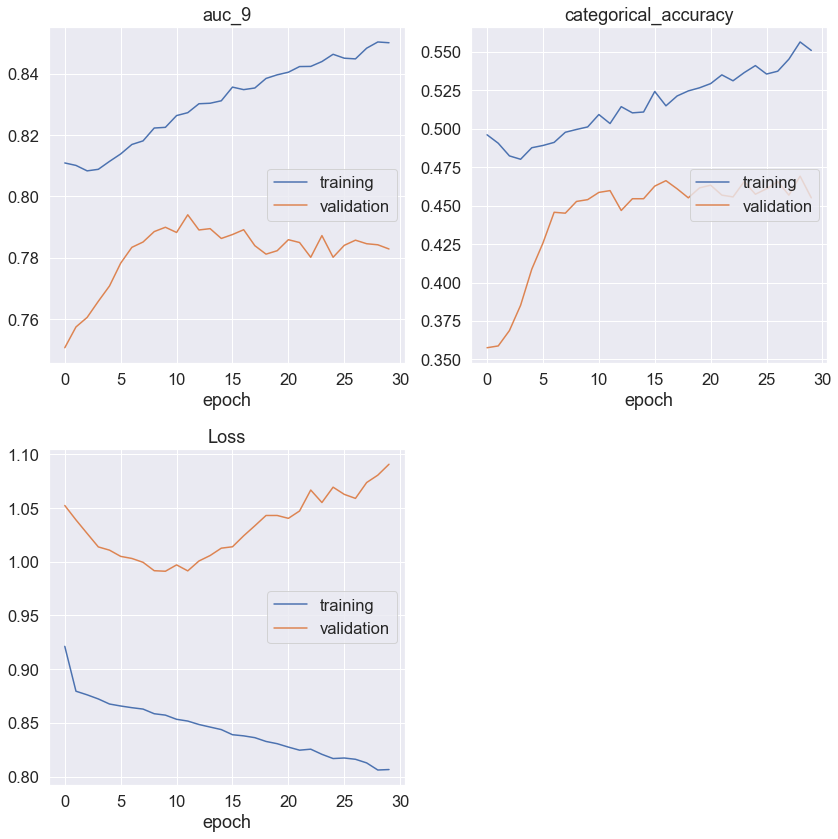

auc_9
	training         	 (min:    0.808, max:    0.850, cur:    0.850)
	validation       	 (min:    0.751, max:    0.794, cur:    0.783)
categorical_accuracy
	training         	 (min:    0.480, max:    0.556, cur:    0.551)
	validation       	 (min:    0.358, max:    0.469, cur:    0.455)
Loss
	training         	 (min:    0.806, max:    0.921, cur:    0.807)
	validation       	 (min:    0.991, max:    1.091, cur:    1.091)
5467/5467 [==============================] - 2s 284us/sample - loss: 0.8065 - categorical_accuracy: 0.5509 - auc_9: 0.8501 - val_loss: 1.0909 - val_categorical_accuracy: 0.4551 - val_auc_9: 0.7828
Training time:0:00:48.916609
1782/1782 [==============================] - 0s 93us/sample - loss: 0.9022 - categorical_accuracy: 0.4770 - auc_9: 0.8122
Accuracy on Test set: 47.70%
|biLSTM_en|
 Error rate = 0.5230078563411896 
 MSE =  0.6127946127946128 
 Accuracy =  0.4769921436588103 
 AUC =  0.5592689292331074 
 F1-score =  0.23859264305177114 
 Fbeta =  0.25154010933093

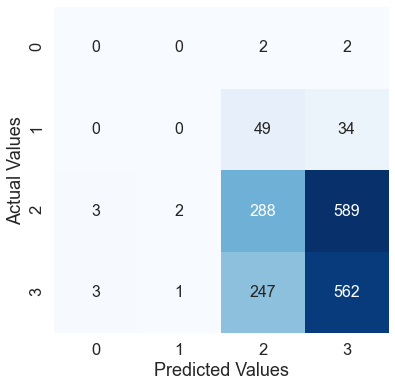

In [22]:
tic = datetime.now()

compile_train(biLSTM_en_model_au,X_train_au,Y_train_cat,X_val_au,Y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

scores = biLSTM_en_model_au.evaluate(X_test_au,Y_test_cat)
print("Accuracy on Test set: %.2f%%" % (scores[1]*100))
print(evaluate_error(biLSTM_en_model_au,X_test_au,Y_test))